# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы будем выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [ ]:
!pip3 install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2023-04-12 13:33:19--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  47.6MB/s    in 4.6s    

2023-04-12 13:33:24 (38.1 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2023-04-12 13:33:24--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  39.9MB/s    in 1.5s    

2023-04-12 13:33:26 (39.9 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2023-04-12 13:33:26--
Total wall clock time: 6.3s
Downloaded: 2 files, 235M i

In [14]:
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR

from torchvision import transforms
import torchvision.datasets as dset

In [4]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [5]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [6]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [7]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [8]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [16]:
def train_model(model, train_loader, val_loader, loss, 
                optimizer, num_epochs, scheduler):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        
        for i_step, (x, y) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)

        scheduler.step()
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % 
              (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    # TODO: Copy implementation from previous assignment 
    # and move the data to device
    
    correct_samples = 0
    total_samples = 0
        
    for i_step, (x, y) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        
        prediction = model(x_gpu)    
        indices = torch.argmax(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y_gpu.shape[0]
        
        return float(correct_samples) / total_samples

In [ ]:
loss_history, train_history, val_history = train_model(
    nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.586919, Train accuracy: 0.823414, Val accuracy: 0.781250
Average loss: 0.540679, Train accuracy: 0.839266, Val accuracy: 0.843750
Average loss: 0.506461, Train accuracy: 0.848923, Val accuracy: 0.828125
Average loss: 0.485558, Train accuracy: 0.856022, Val accuracy: 0.812500
Average loss: 0.462502, Train accuracy: 0.861960, Val accuracy: 0.828125


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [10]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, interpolation=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, 
                                               batch_size=batch_size, 
                                               sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

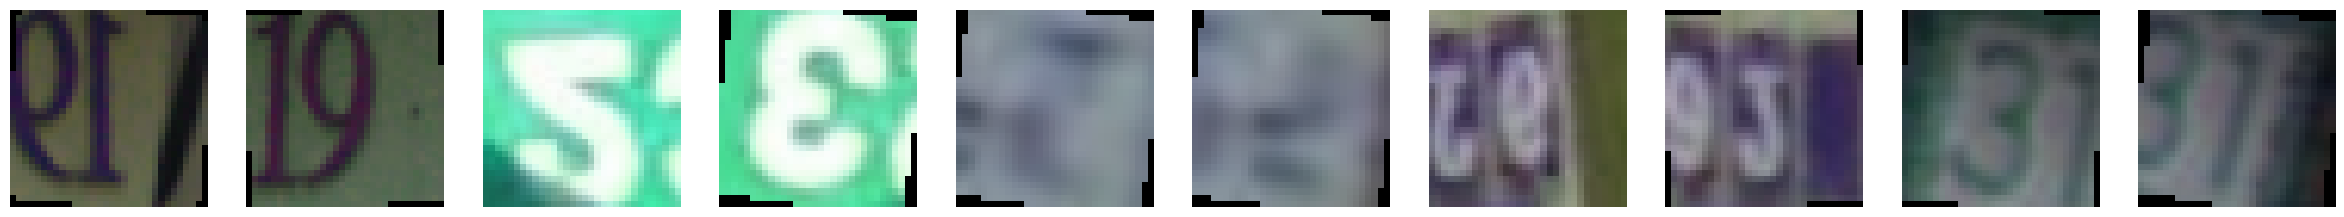

In [11]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, interpolation=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [12]:
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, interpolation=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./', transform=tfs)
train_aug_loader = torch.utils.data.DataLoader(data_aug_train, 
                                               batch_size=batch_size, 
                                               sampler=train_sampler)

In [ ]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(
    nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.578908, Train accuracy: 0.823039, Val accuracy: 0.890625
Average loss: 0.534614, Train accuracy: 0.836194, Val accuracy: 0.906250
Average loss: 0.512094, Train accuracy: 0.845152, Val accuracy: 0.875000
Average loss: 0.496148, Train accuracy: 0.848650, Val accuracy: 0.812500
Average loss: 0.486980, Train accuracy: 0.853206, Val accuracy: 0.906250


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [13]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
    nn.Conv2d(3, 6, 5),
    nn.Tanh(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(6, 16, 5),
    nn.Tanh(),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),

    nn.Linear(5*5*16, 120),
    nn.Tanh(),

    nn.Linear(120, 84),
    nn.Tanh(),

    nn.Linear(84, 10),
    nn.Tanh()
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [ ]:
# Let's train it!
loss_history, train_history, val_history = train_model(
    lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.673473, Train accuracy: 0.531533, Val accuracy: 0.812500
Average loss: 1.179888, Train accuracy: 0.802017, Val accuracy: 0.859375
Average loss: 1.104005, Train accuracy: 0.833038, Val accuracy: 0.812500
Average loss: 1.072081, Train accuracy: 0.847234, Val accuracy: 0.875000
Average loss: 1.050261, Train accuracy: 0.857881, Val accuracy: 0.906250
Average loss: 1.035855, Train accuracy: 0.864144, Val accuracy: 0.890625
Average loss: 1.026658, Train accuracy: 0.869143, Val accuracy: 0.875000
Average loss: 1.017262, Train accuracy: 0.873972, Val accuracy: 0.906250
Average loss: 1.008449, Train accuracy: 0.879773, Val accuracy: 0.890625
Average loss: 1.003512, Train accuracy: 0.881019, Val accuracy: 0.859375


# Подбор гиперпараметров

In [18]:
# The key hyperparameters we're going to tune are learning speed, 
# annealing rate and regularization (+ different optimizers)

Hyperparams = namedtuple("Hyperparams", 
                         ['learning_rate', 'regs', 'anneal_epochs'])
RunResult = namedtuple("RunResult", 
                       ['model', 'loss_history', 
                        'train_history', 'val_history'])

learning_rates = [1e-0, 1e-1, 1e-2, 1e-3, 1e-4]
anneal_coeff = 0.2
anneal_epochs = [5, 15, 20, 50]
regs = [1e-3, 1e-4, 1e-5, 1e-7]

batch_size = 64
epoch_num = 10

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# Use grid search or random search and record all runs in run_record 
# dictionary. Important: perform search in logarithmic space!

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

for learning_rate in learning_rates:
  for reg in regs:
    for anneal_epoch in anneal_epochs:

      loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
      optimizer = optim.SGD(lenet_model.parameters(), lr=learning_rate, 
                            weight_decay=reg)
      
      scheduler = StepLR(optimizer, step_size=anneal_epoch, 
                         gamma=0.2, verbose=True)
      
      key = Hyperparams(learning_rate, reg, anneal_epoch)
      print(f'Current hyperparameters: {key}\n')
      
      loss_history, train_history, val_history = train_model(
          lenet_model, train_aug_loader, val_loader, loss, 
          optimizer, 10, scheduler=scheduler)
      
      value = RunResult(lenet_model, loss_history, train_history, val_history)
      run_record[key] = value

Adjusting learning rate of group 0 to 1.0000e+00.
Current hyperparameters: Hyperparams(learning_rate=1.0, regs=0.001, anneal_epochs=5)

Adjusting learning rate of group 0 to 1.0000e+00.
Average loss: 1.273339, Train accuracy: 0.725369, Val accuracy: 0.843750
Adjusting learning rate of group 0 to 1.0000e+00.
Average loss: 1.212812, Train accuracy: 0.761031, Val accuracy: 0.703125
Adjusting learning rate of group 0 to 1.0000e+00.
Average loss: 1.199943, Train accuracy: 0.767140, Val accuracy: 0.718750
Adjusting learning rate of group 0 to 1.0000e+00.
Average loss: 1.198375, Train accuracy: 0.768164, Val accuracy: 0.828125
Adjusting learning rate of group 0 to 2.0000e-01.
Average loss: 1.183550, Train accuracy: 0.776303, Val accuracy: 0.750000
Adjusting learning rate of group 0 to 2.0000e-01.
Average loss: 1.057688, Train accuracy: 0.849521, Val accuracy: 0.843750
Adjusting learning rate of group 0 to 2.0000e-01.
Average loss: 1.035896, Train accuracy: 0.864314, Val accuracy: 0.859375
Adj

KeyboardInterrupt: ignored

In [23]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or \
    best_val_accuracy < run_result.val_history:
        best_val_accuracy = run_result.val_history
        best_hyperparams = hyperparams
        best_run = run_result
        
print(max(best_val_accuracy))
print(best_hyperparams)

0.90625
Hyperparams(learning_rate=1.0, regs=0.0001, anneal_epochs=5)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [ ]:
LeNet = nn.Sequential(
    nn.BatchNorm2d(3),
    nn.Conv2d(3, 16, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(16, 32, 3),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(32, 64, 3),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2, 2),

    nn.Linear(8*8*64, 256),
    nn.Tanh(),
    nn.BatchNorm2d(256),

    nn.Linear(256, 64),
    nn.Tanh(),
    nn.BatchNorm2d(64),

    nn.Linear(64, 10))

In [ ]:
LeNet.type(torch.cuda.FloatTensor)
LeNet.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(LeNet.parameters(), lr=learning_rate, 
                      weight_decay=reg)
      
scheduler = StepLR(optimizer, step_size=anneal_epoch, 
                    gamma=0.2, verbose=True)
      
loss_history, train_history, val_history = train_model(
    LeNet, train_aug_loader, val_loader, loss, 
    optimizer, 10, scheduler=scheduler)

best_val_accuracy = None
best_model = None

current_val_history = max(val_history)

if (best_val_accuracy == None) or (current_val_history > best_val_accuracy):
    best_model = LeNet
    best_val_accuracy = current_val_history
        
print('Best validation accuracy achieved: %f' % best_val_accuracy)

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [ ]:
# TODO Write the code to compute accuracy on test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
final_test_accuracy = compute_accuracy(LeNet, )
print("Final test accuracy - ", final_test_accuracy)